# Project 3: ML Regression


The notebook explains how to create a ML regression model to predict demand for bikesharing vehicles. Bikesharing data are available here: https://www.kaggle.com/c/bike-sharing-demand. The notebook was developed as as study project for the Spiced Academy Data Science Bootcamp.

## Imports

In [725]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures, OrdinalEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures



In [726]:
plt.rcdefaults()

## Business goal

???? Build a model that is able to predict the number of bikes rented (target variable "count" that sums the bikes rented by casual and registered users of the bikesharing service) according to the weather conditions and the hour of the day (depending on the day of the week). ????

## Reading data

In [727]:
train = './kaggle_data/train.csv'
df = pd.read_csv(train, parse_dates=True, index_col=0)

In [728]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


## Extracting the date-time information available in the index

In [729]:
#Extracting the time/date information from the index
df['year'] = df.index.year
df['month'] = df.index.month_name()
df['day'] = df.index.day_name()
df['hour'] = df.index.hour

In [730]:
df


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,January,Saturday,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,January,Saturday,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,January,Saturday,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,January,Saturday,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,January,Saturday,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,December,Wednesday,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,December,Wednesday,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,December,Wednesday,21


In [731]:
cols = df.columns.tolist()
print (cols)

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'month', 'day', 'hour']


In [732]:
# Rearranging the df columns
cols = cols[-4:] +cols[:-4]
print(cols)

['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


In [733]:
df = df[cols]

In [734]:
df

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011,January,Saturday,0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,2011,January,Saturday,1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,2011,January,Saturday,2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,2011,January,Saturday,3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,2011,January,Saturday,4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,2012,December,Wednesday,19,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,2012,December,Wednesday,20,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,2012,December,Wednesday,21,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


## Exploratory data analysis

In [735]:
#Checking if there are missing values in the dataframe. None in this case.
df.isnull().values.any()

False

In [736]:
# datatypes in the dataframe. Only integers and floats
df.dtypes

year            int64
month          object
day            object
hour            int64
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [737]:
#time period examined. The data are (roughly) equally distributed between the two years accounted for
df['year'].value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [738]:
#seasons examined. The data are (roughly) equally distributed throughout the year
#(1=spring, 4=winter)
df['season'].value_counts()

4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64

In [739]:
#mean of the counts per hour
df[['hour', 'count']].groupby('hour').mean()


,count
hour,
0,55.138462
1,33.859031
2,22.899554
3,11.757506
4,6.407240
5,19.767699
6,76.259341
7,213.116484
8,362.769231


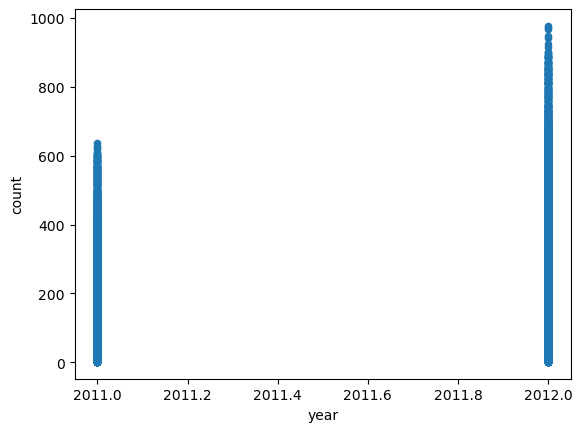

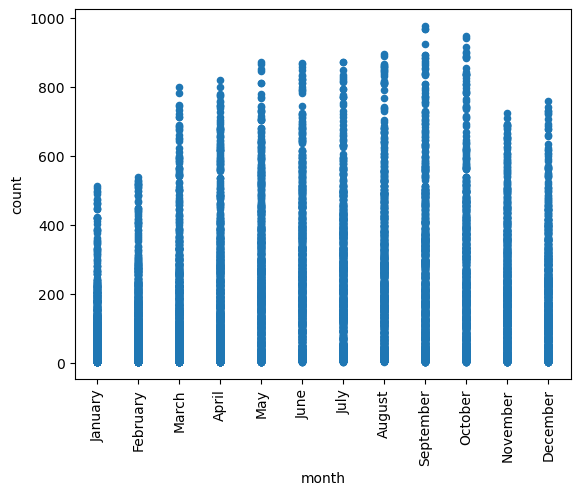

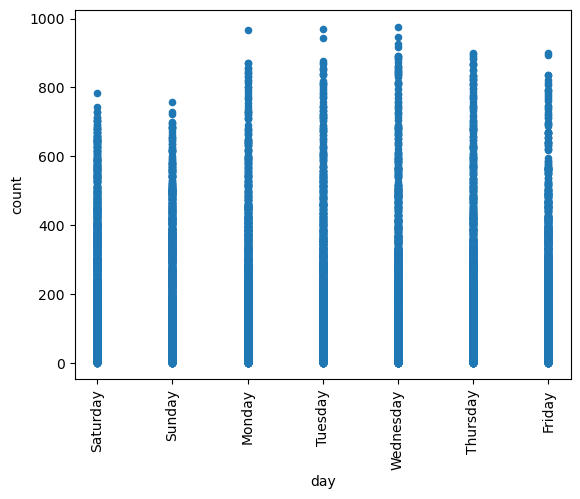

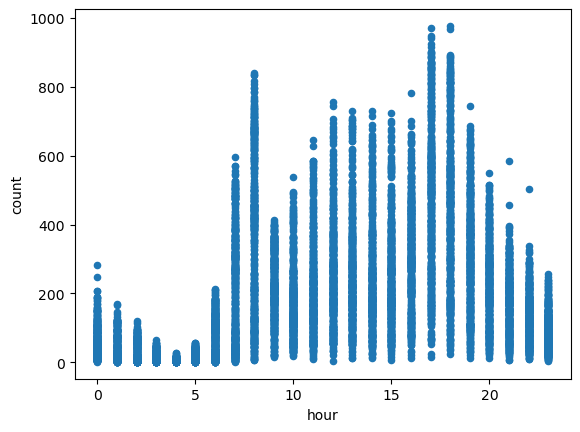

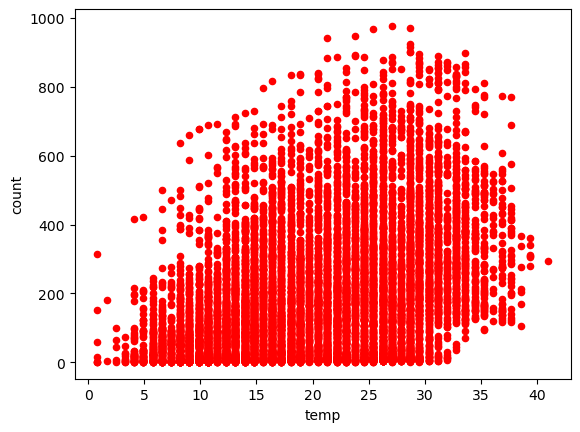

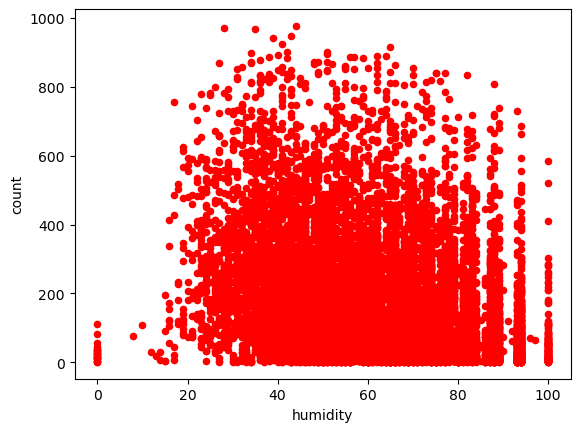

In [740]:
###Checking how datetime and atmospheric variables (temperature and humidity) impact on the 
#number of bicycles rented
df.plot.scatter(x='year', y ='count')
df.plot.scatter(x='month', y ='count', rot =90)
df.plot.scatter(x='day', y ='count', rot = 90)
df.plot.scatter(x='hour', y ='count')
df.plot.scatter(x='temp', y ='count', c='red')
df.plot.scatter(x='humidity', y ='count', c='red');

In [741]:
#Bike sharing habits of casual and registered users
reg_month = df[['registered','month']].groupby('month').mean()
cas_month = df[['casual','month']].groupby('month').mean()
reg_day = df[['registered','day']].groupby('day').mean()
cas_day = df[['casual','day']].groupby('day').mean()
reg_hour = df[['registered','hour']].groupby('hour').mean()
cas_hour = df[['casual','hour']].groupby('hour').mean()

month_habit = reg_month.merge(cas_month, left_index=True, right_index = True)
day_habit = reg_day.merge(cas_day, left_index=True, right_index = True)
hour_habit = reg_hour.merge(cas_hour, left_index=True, right_index = True)

print(month_habit)
print(day_habit)
print(hour_habit)


           registered     casual
month                           
April      140.361936  43.798680
August     183.822368  50.296053
December   159.495614  16.118421
February    99.684795  10.318535
January     82.162896   8.203620
July       179.462719  55.862939
June       188.770833  53.260965
March      120.360710  27.809101
May        174.190789  45.268640
November   165.847420  27.829857
October    185.891328  41.807903
September  183.309131  50.496150
           registered     casual
day                             
Friday     166.842381  31.001962
Monday     160.546744  29.843972
Saturday   133.040404  63.625000
Sunday     123.788474  57.051298
Thursday   173.289118  24.007083
Tuesday    166.744639  22.979207
Wednesday  165.889749  22.521599
      registered     casual
hour                       
0      44.826374  10.312088
1      27.345815   6.513216
2      18.080357   4.819196
3       9.076212   2.681293
4       5.144796   1.262443
5      18.311947   1.455752
6      72.109890 

A few considerations about the data.
- In the two years examined, the bike sharing system experiences a growth of about 30%.
- During the coldest winter months (January and February) the bikesharing system is used less.
- Weekly trend: working days see an increased use of the bikesharing system compared to weekends. 
- Hourly trend: There are evident fluctuations with minimal use of the bikesharing system during the night (ca. 11pm-6am) and peaks at 8am and 5-6 pm. Averages for the counts are listed above for each hour.
- Atmospheric variables (temperature and humidity). Atmospheric variables have a less clearly defined relationship to the counts. As expected, the vehicles of the bike sharing system are less used when the temperatures are too low (<10°C) or too high(>35°C) and when the relative humidity values are extreme (<30% or >90%), which also is an indication of the overall weather conditions (very low relative humidity = very cold, very high relative humidity = rain). The relationship existing between counts, temperature and humidity variables is however hardly linear.
- The distribution of registered and casual users according to month/day/hour is in line with what expected, i.e. casual users are mostly to be found in warm months (June to September), at weekends, and in the afternoon. 


## Feature engineering

In [742]:
#Encoding in numerical format the information available on month and day 
#in order to include it in the correlation matrix
months = df['month'].unique().tolist()
months_numb = [x for x in range(1,13)]
months_dict = dict(zip(months, months_numb))
df['month'].replace(months_dict, inplace=True)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_numb = [x for x in range(0,7)]
days_dict = dict(zip(days, days_numb))
df['day'].replace(days_dict, inplace=True)




/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [743]:
df

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011,1,5,0,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,2011,1,5,1,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,2011,1,5,2,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,2011,1,5,3,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,2011,1,5,4,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,2012,12,2,19,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,2012,12,2,20,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,2012,12,2,21,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


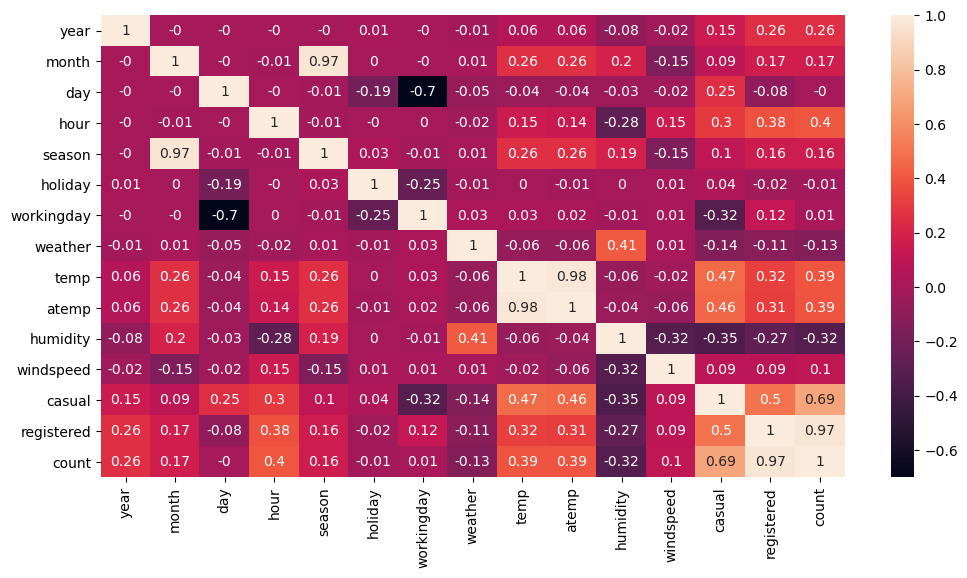

In [744]:
#Heatmap (representing the correlation matrix) of the data features
plt.rcParams['figure.figsize'] = (12,6)

sns.heatmap(round(df.corr(), 2), annot=True);

** The heatmap suggests that the target, i.e. the count column is actually correlated to the weather conditions and that the interesting features are temp (positive correlation) and humidity (negative correlation). In my model I will consider as features the date-time information (year, month, day, hour, and holiday) and the weather information (temp, humidity).

In [745]:
#I start selecting the train dataset (i.e. dropping the target column, count, 
#and the registered and casual columns of which count is the sum.
X_train = df.drop(['casual', 'registered', 'count'], axis=1)
y_train = df['count']

In [746]:
X_train

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,2011,1,5,0,1,0,0,1,9.84,14.395,81,0.0000
2011-01-01 01:00:00,2011,1,5,1,1,0,0,1,9.02,13.635,80,0.0000
2011-01-01 02:00:00,2011,1,5,2,1,0,0,1,9.02,13.635,80,0.0000
2011-01-01 03:00:00,2011,1,5,3,1,0,0,1,9.84,14.395,75,0.0000
2011-01-01 04:00:00,2011,1,5,4,1,0,0,1,9.84,14.395,75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,2012,12,2,19,4,0,1,1,15.58,19.695,50,26.0027
2012-12-19 20:00:00,2012,12,2,20,4,0,1,1,14.76,17.425,57,15.0013
2012-12-19 21:00:00,2012,12,2,21,4,0,1,1,13.94,15.910,61,15.0013


In [747]:
#Column transformer to encode year, month, day, hour, holiday 
#and rescale temperature and humidity
trans = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(sparse=False, handle_unknown='ignore'), 
     ['year', 'month', 'day', 'hour','holiday']),
    ('scale', MinMaxScaler(), ['temp', 'humidity']),
     ])

In [748]:
#fitting the transformer
trans.fit(X_train, y_train)

ColumnTransformer(transformers=[('one_hot_enc',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['year', 'month', 'day', 'hour', 'holiday']),
                                ('scale', MinMaxScaler(),
                                 ['temp', 'humidity'])])

In [749]:
#transformed set of value to feed into the model
X_train_trans = trans.transform(X_train)

## Linear regression

In [750]:
model_lr = LinearRegression()

In [751]:
model_lr.fit(X_train_trans, y_train)

LinearRegression()

### Cross validation for linear regression

In [752]:
cross_validation = cross_validate(model_lr,
              X_train_trans,
              y_train,
              cv=5,
              return_train_score=True)

In [753]:
cross_validation

{'fit_time': array([0.02074909, 0.01454687, 0.00755525, 0.00826788, 0.00713611]),
 'score_time': array([0.001055  , 0.00068307, 0.00060701, 0.00112009, 0.00067782]),
 'test_score': array([0.0186521 , 0.67394025, 0.54095266, 0.63603952, 0.62890776]),
 'train_score': array([0.69760651, 0.68381573, 0.69162596, 0.67543251, 0.68368714])}

In [754]:
cross_validation['train_score'].mean()

0.6864335714922303

In [755]:
cross_validation['test_score'].mean()

0.49969845877159713

In [756]:
model_lr.score(X_train_trans, y_train)

0.6840851577283946

The cross validation suggest that the model is overfitting because the test score is only about half of the train score. In order to see how the result is due to the correlation among the weather variables (temperature and humidity), I recompute the model eliminating humidity.

In [757]:
"""
trans_only_temp = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(sparse=False, handle_unknown='ignore'), 
     ['year', 'month', 'day', 'hour','holiday']),
    ('scale', MinMaxScaler(), ['temp']),
     ])
trans_only_temp.fit(X_train, y_train)
X_train_trans_only_temp = trans_only_temp.transform(X_train)
model_lr_only_temp = LinearRegression()
model_lr_only_temp.fit(X_train_trans_only_temp, y_train)
cross_validation_only_temp = cross_validate(model_lr_only_temp,
              X_train_trans_only_temp,
              y_train,
              cv=5,
              return_train_score=True)
print(round(cross_validation_only_temp['train_score'].mean(),3))
print(round(cross_validation_only_temp['test_score'].mean(),3))
print(round(model_lr_only_temp.score(X_train_trans_only_temp, y_train),3))
"""


"\ntrans_only_temp = ColumnTransformer([\n    ('one_hot_enc', OneHotEncoder(sparse=False, handle_unknown='ignore'), \n     ['year', 'month', 'day', 'hour','holiday']),\n    ('scale', MinMaxScaler(), ['temp']),\n     ])\ntrans_only_temp.fit(X_train, y_train)\nX_train_trans_only_temp = trans_only_temp.transform(X_train)\nmodel_lr_only_temp = LinearRegression()\nmodel_lr_only_temp.fit(X_train_trans_only_temp, y_train)\ncross_validation_only_temp = cross_validate(model_lr_only_temp,\n              X_train_trans_only_temp,\n              y_train,\n              cv=5,\n              return_train_score=True)\nprint(round(cross_validation_only_temp['train_score'].mean(),3))\nprint(round(cross_validation_only_temp['test_score'].mean(),3))\nprint(round(model_lr_only_temp.score(X_train_trans_only_temp, y_train),3))\n"

The new results are not significantly different. It seems that the humidity information can be worth remaining in the model and it is the linear model itself that does not perform suitably in this case. I will therefore test polynomial regression to compare performance.

## Kaggle evaluation

In [758]:
test = './kaggle_data/test.csv'
df_data = pd.read_csv(test, parse_dates=True, index_col=0)

In [759]:
df_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014


In [760]:
df_data['year'] = df_data.index.year
df_data['month'] = df_data.index.month_name()
df_data['day'] = df_data.index.day_name()
df_data['hour'] = df_data.index.hour


In [761]:
cols_data = df_data.columns.to_list()
cols_ord = cols_data[-4:] + cols_data[:-4]
df_data = df_data[cols_ord]


In [762]:
df_data

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,2011,January,Thursday,0,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,2011,January,Thursday,1,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,2011,January,Thursday,2,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,2011,January,Thursday,3,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,2011,January,Thursday,4,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,2012,December,Monday,19,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,2012,December,Monday,20,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,2012,December,Monday,21,1,0,1,1,10.66,12.880,60,11.0014


In [763]:
months = df_data['month'].unique().tolist()
months_numb = [x for x in range(1,13)]
months_dict = dict(zip(months, months_numb))
df_data['month'].replace(months_dict, inplace=True)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_numb = [x for x in range(0,7)]
days_dict = dict(zip(days, days_numb))
df_data['day'].replace(days_dict, inplace=True)

/Users/giudittaparolini/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [764]:
df_data.dtypes


year            int64
month           int64
day             int64
hour            int64
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [765]:
X_test_transform = trans.transform(df_data)



In [766]:
X_test_transform

array([[1.        , 0.        , 1.        , ..., 0.        , 0.24489796,
        0.56      ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.24489796,
        0.56      ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.24489796,
        0.56      ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.24489796,
        0.6       ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.24489796,
        0.56      ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.24489796,
        0.65      ]])

In [767]:
ypred_lr = model_lr.predict(X_test_transform)

print(ypred_lr)

[ -75.5   -91.5  -101.25 ...  192.25  162.25  111.  ]


In [768]:
#The values predicted by the regression are also negative and non-integer. In order to have 
#a submission that is compatible with the problem I take the abs and round. All in all, what is 
#evident is that linear regression is a totally unsuitable model for this problem
ypred_lr = np.round_(np.abs(ypred_lr),0)

In [769]:
submission_lr = pd.DataFrame(ypred_lr, index=df_data.index, columns=['count'])
submission_lr.to_csv('submission_lr_bikesharing.csv')

In [770]:
model_lr.intercept_

1756777953814762.8

In [771]:
model_lr.coef_

array([ 7.56475365e+14,  7.56475365e+14, -6.58749731e+12, -6.58749731e+12,
       -6.58749731e+12, -6.58749731e+12, -6.58749731e+12, -6.58749731e+12,
       -6.58749731e+12, -6.58749731e+12, -6.58749731e+12, -6.58749731e+12,
       -6.58749731e+12, -6.58749731e+12, -1.64761040e+15, -1.64761040e+15,
       -1.64761040e+15, -1.64761040e+15, -1.64761040e+15, -1.64761040e+15,
       -1.64761040e+15, -3.97578339e+14, -3.97578339e+14, -3.97578339e+14,
       -3.97578339e+14, -3.97578339e+14, -3.97578339e+14, -3.97578339e+14,
       -3.97578339e+14, -3.97578339e+14, -3.97578339e+14, -3.97578339e+14,
       -3.97578339e+14, -3.97578339e+14, -3.97578339e+14, -3.97578339e+14,
       -3.97578339e+14, -3.97578339e+14, -3.97578339e+14, -3.97578339e+14,
       -3.97578339e+14, -3.97578339e+14, -3.97578339e+14, -3.97578339e+14,
       -3.97578339e+14, -4.61477083e+14, -4.61477083e+14,  1.99512695e+02,
       -1.18070312e+02])

<AxesSubplot:xlabel='temp', ylabel='count'>

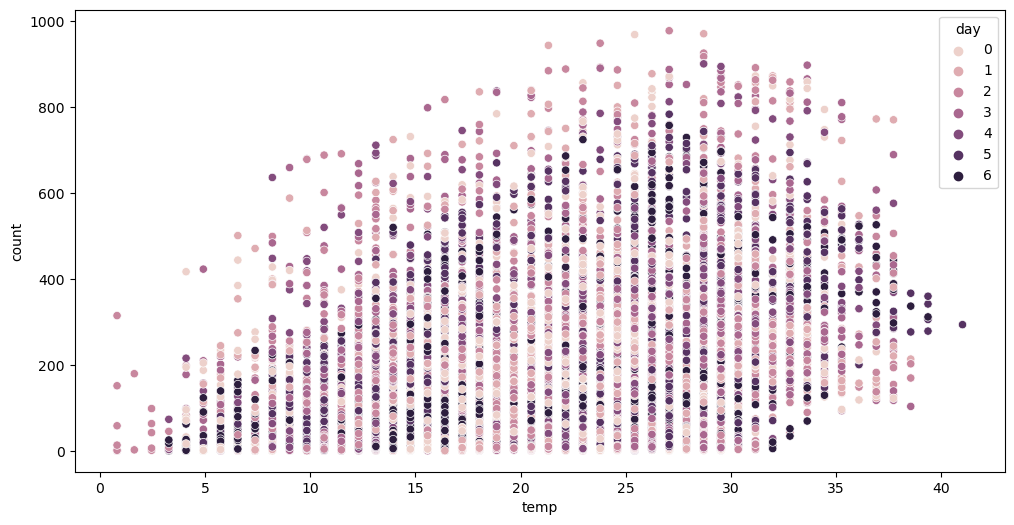

In [772]:
#MAKE A PLOT
#sns.lineplot(x=X_train['temp'], y=y_pred)
sns.scatterplot(x='temp', y=y_train, data=X_train, hue=df['day'])

## Polynomial Regression


## Random forest regressor

<AxesSubplot:>

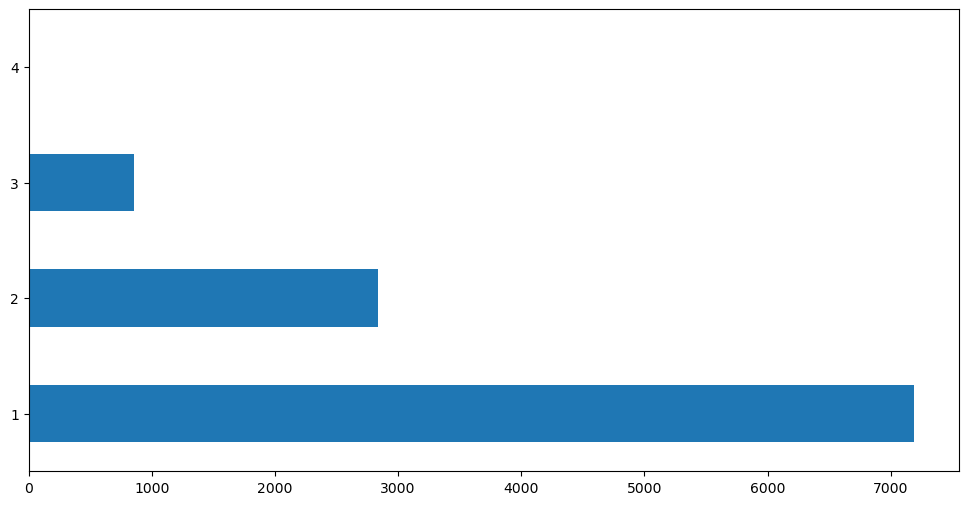

In [773]:
df['weather'].value_counts().plot(kind ='barh')


In [774]:
weather_lst = df['weather'].unique().tolist()

In [775]:
weather_lst

[1, 2, 3, 4]

In [776]:
weather_casual = []
for weather in weather_lst:
    casual_n = df[df['weather']== weather]['casual'].sum()
    weather_casual.append(casual_n)
    
print(weather_casual)

[289900, 87246, 14983, 6]


In [777]:
weather_registered = []
for weather in weather_lst:
    casual_n = df[df['weather']== weather]['registered'].sum()
    weather_registered.append(casual_n)
    
print(weather_registered)

[1186163, 419914, 87106, 158]


No handles with labels found to put in legend.


Text(0, 0.5, 'Bikesharing users')

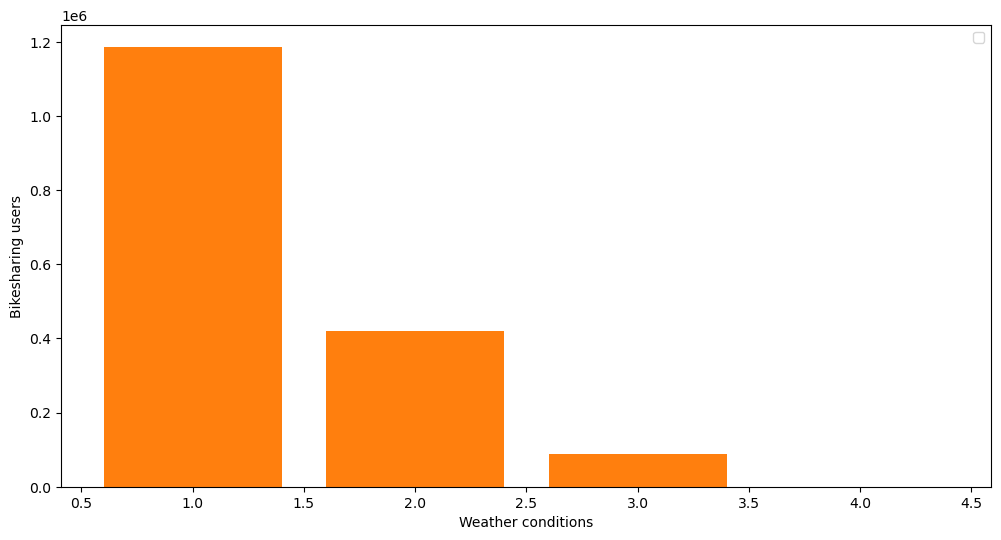

In [778]:
x = weather_lst
y1 = weather_casual
y2 = weather_registered

fig, axes = plt.subplots()
plt.bar(x,y1) 
plt.bar(x,y2) 
plt.legend(loc='best')
plt.xlabel('Weather conditions')
plt.ylabel('Bikesharing users')

weather
1    AxesSubplot(0.125,0.2;0.775x0.68)
2    AxesSubplot(0.125,0.2;0.775x0.68)
3    AxesSubplot(0.125,0.2;0.775x0.68)
4    AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

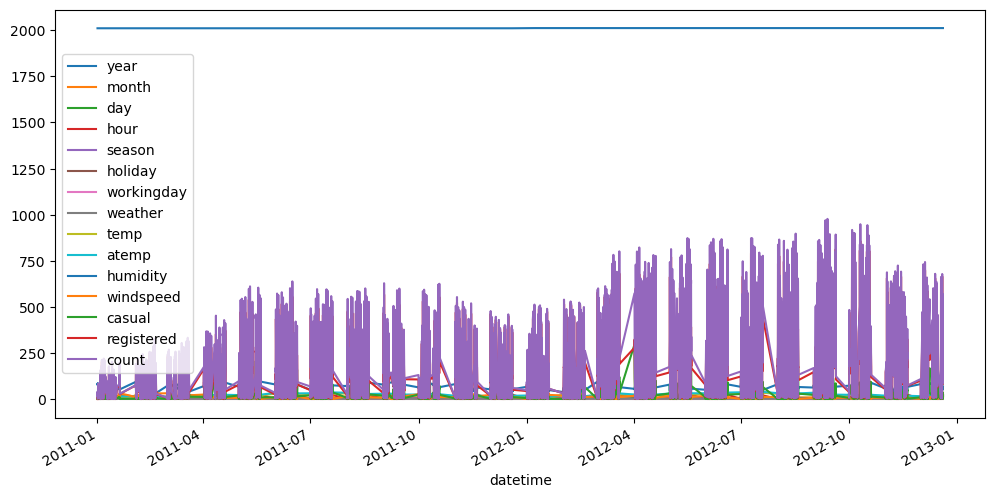

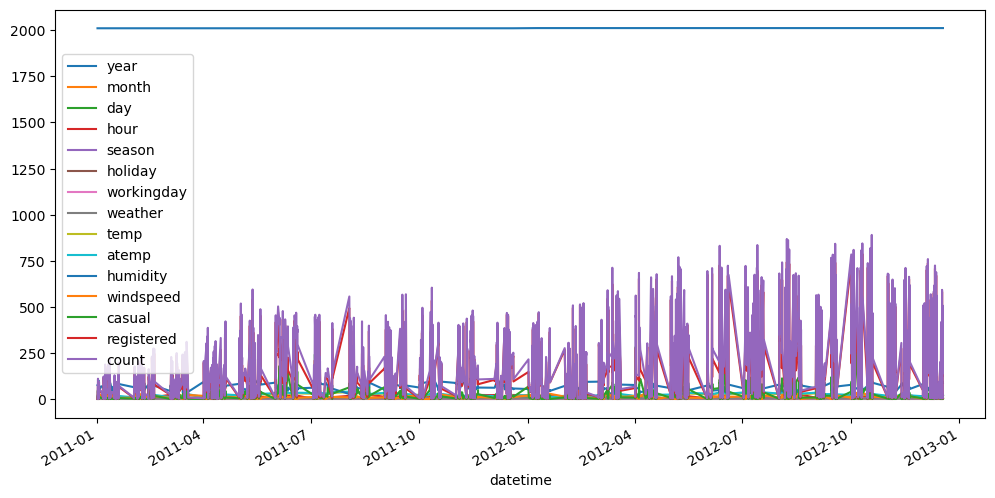

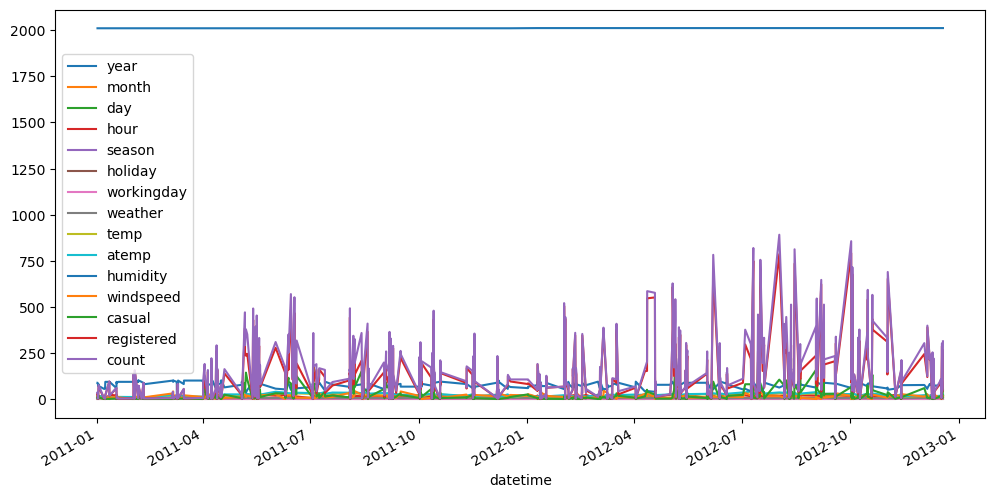

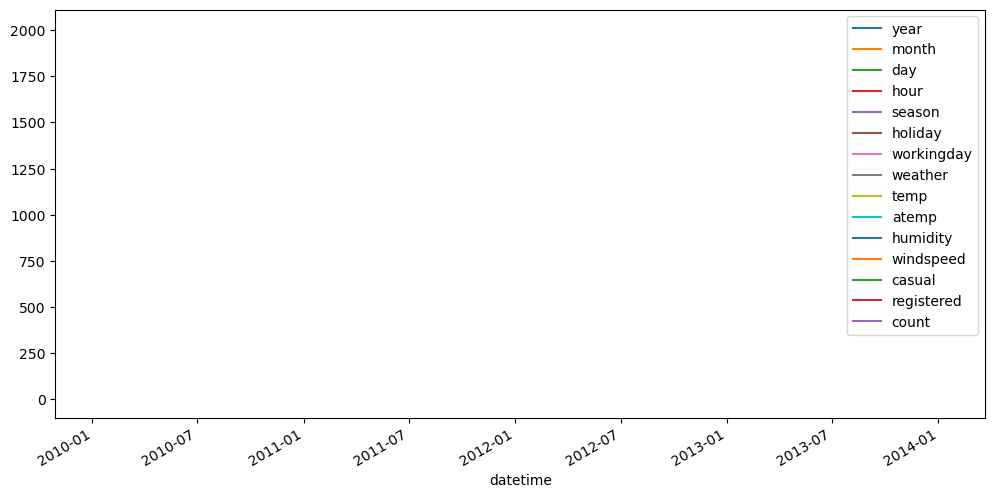

In [779]:
#Casual and registered rentals divided per weather condition
df.groupby('weather').plot()

## Feature Engineer

In [780]:
X_train, y_train = feature_engineering(df)

NameError: name 'feature_engineering' is not defined

## Train a model / multiple models

In [ ]:
m = LinearRegression()
m.fit(X_train,y_train)

## Model evaluation / model selection - Cross-Validation

Go back to EDA and Feature Engineering part to improve your model and only once you are happy with the results go on!

## Test on unseen data

In [ ]:
test = './data/test.csv'
df = pd.read_csv(test, parse_dates=True, index_col=0)

In [ ]:
X_test = feature_engineering(df, test=True)

In [ ]:
prediction_to_csv(X_test,m)